# Insights


#### Introduction 

Released on October 27, 2009, League of Legends (LoL) is a multiplayer online battle arena video game developed and published by Riot Games for Microsoft Windows and macOS. 

LOL is a complex game where 5 players of the blue team are fighting 5 players of the red team in a cruel match.

Each team works together to achieve victory either by destroying the enemy team's Nexus, after bypassing a line of defensive structures called turrets or towers, or by forcing the enemy team to surrender through a vote.

With that being said, the dataset used in this project contains the early game (first 10mins of the game) stats of approx. 10k high ELO ranked games.


#### Dataset columns

blueWins: Blue Team wins or loses

WardsPlaced: Number of warding totems placed by the team on the map

WardsDestroyed : Number of enemy warding totems the team has destroyed

FirstBlood: First kill of the game. 1 if the team got the first kill, 0 if not

Kills: Number of enemies killed by the team

Deaths: Number of deaths

Assists: Number of kill assists

EliteMonsters: Number of elite monsters killed by the team (Dragons and Heralds)

Dragons: Number of dragons killed by the team

Heralds : Number of heralds killed by the team

TowersDestroyed: Number of structures destroyed by the team

TotalGold: Team total gold

AvgLevel: Team average champion level

TotalExperience: Team total experience

TotalMinionsKilled: Team total minions killed (CS)

TotalJungleMinionsKilled: Team total jungle monsters killed

GoldDiff: Team gold difference compared to the enemy team

ExperienceDiff: Team experience difference compared to the enemy team

CSPerMin: Team CS (minions) per minute

GoldPerMin: Team gold per min

#### Objective 

The aim of this project is to train and test several classification algorithms and choose the best one to be used to predict the outcome of a match based solely on the early game stats.

# Imports

In [1]:
#Data loading and visualization imports

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mplt
import seaborn as sns
%matplotlib inline

#Machine learning imports

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


# Loading data

In [2]:
lol_df = pd.read_csv('high_diamond_ranked_10min.csv')

lol_df.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


# Data pre-processing

In [3]:
# General informations

lol_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

The dataset contains 9879 entries (matches) with a total of 40 columns providing both red and blue team stats. In addition to a target column "blueWins" that determines which of one of the teams actually ended up winning.

##### Note:
All features values seem to be numerical (floats or ints) so it is safe to assume that feature transformation step can be skipped

In [4]:
# Looking for missing values

lol_df.isnull().sum().sum()

0

Data contains no missing values

In [5]:
# Dropping gameId column 

lol_df.drop( labels = ['gameId',], axis = 1, inplace = True)

In [6]:
# Spliting blue team and red team stats

bt_stats = lol_df.iloc[:, 0:20]

rt_stats = lol_df.iloc[:, 20:]

#### For the rest of the work  we will focus only on visualising the blue team stats and building a prediction model for the blue team since predicting a team's win/loss is predicting the other team's win/loss as well.

# Data visualisation

The purpose of this part is to get a grasp on the different relations between a team's win/loss and the stats contributing to that particular outcome

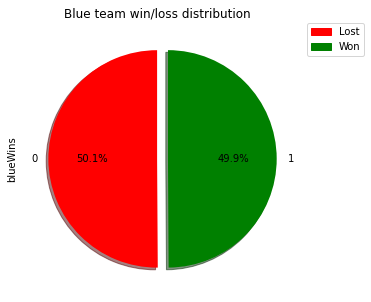

In [7]:
# win/loss distribution

plt.figure(figsize = (10,5))
plt.title('Blue team win/loss distribution')
#sns.countplot(lol_df.blueWins, palette = ['r', 'g'])
lol_df.blueWins.value_counts().plot.pie( colors = ['r', 'g'], autopct = "%1.1f%%", explode = (0, 0.1), 
                                           shadow = True, startangle = 90 )
plt.legend(bbox_to_anchor = (1.05, 1), loc = "upper left", borderaxespad = 0.,handles = [mplt.patches.Patch(color = "r", label = 'Lost'),mplt.patches.Patch(color = "g",label = 'Won')])


The dataset is well balanced and we almost have the same number of won and lost games.

The factors that have the highest impact on the game outcome are gold difference, experience/levels difference and epic monsters killed.

### Gold difference

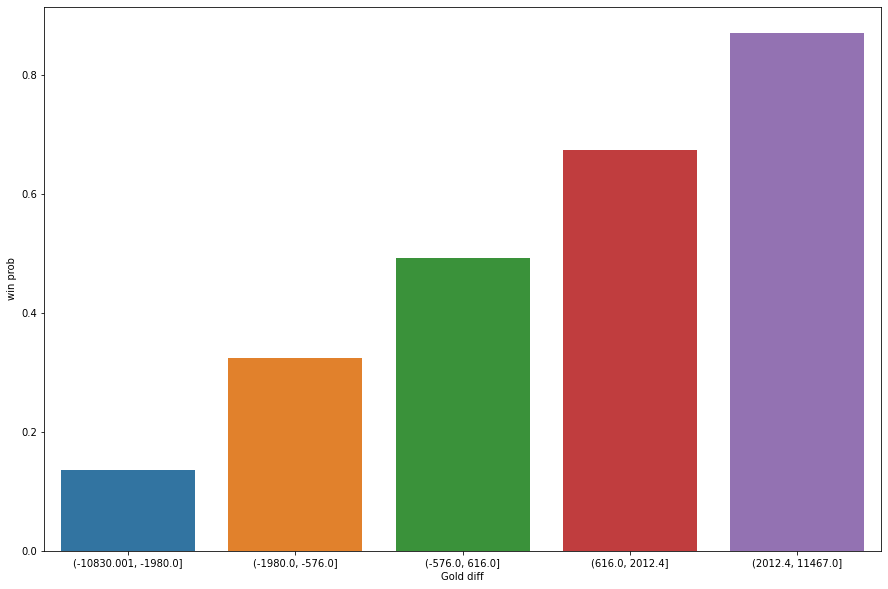

In [8]:

bt_stats['blueGoldDiffBins'] = pd.qcut(bt_stats['blueGoldDiff'], q = 5, duplicates='drop')

win_prob = bt_stats.groupby('blueGoldDiffBins')['blueWins'].mean()
win_prob = win_prob.reset_index()
win_prob.columns = ['Gold diff', 'win prob']

plt.figure(figsize = (15,10))
sns.barplot(x = 'Gold diff', y = 'win prob', data = win_prob)

The higher the gold difference, the better the probability of winning. This is due to the fact that gold is the most important resource in the game and the team with the higher gold income will generally have better items thus will be stronger than opposing team


While gold difference is a standalone feature, it's actually the aggregation of multiple sub-factors. We'll try to visualize some of them


#### First blood

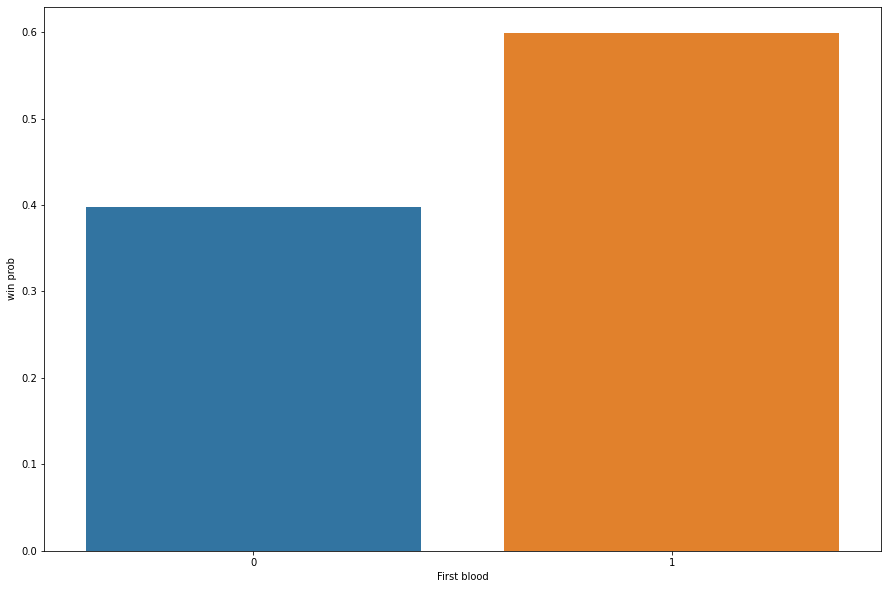

In [9]:


win_prob = bt_stats.groupby('blueFirstBlood')['blueWins'].mean()
win_prob = win_prob.reset_index()
win_prob.columns = ['First blood', 'win prob']

plt.figure(figsize = (15,10))
sns.barplot(x = 'First blood', y = 'win prob', data = win_prob)

Obviously, the team has a better chance of winning when they get first blood due to the extras gold and exp won as a reward.

#### Kills/Deaths
The number of kills itself is not as important as the difference in kills between the two teams.

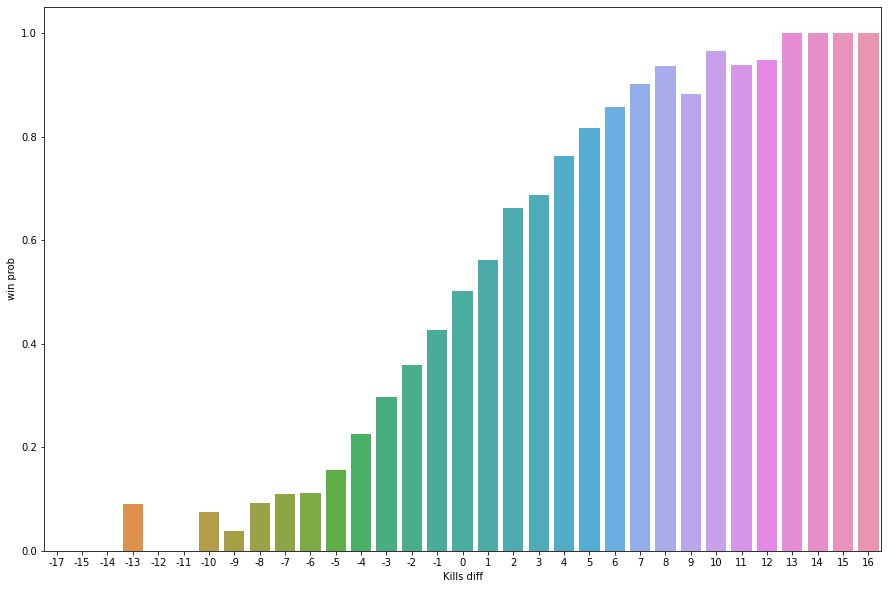

In [10]:
bt_stats['blueKillsDiff'] = bt_stats['blueKills'] - rt_stats['redKills']


win_prob = bt_stats.groupby('blueKillsDiff')['blueWins'].mean()
win_prob = win_prob.reset_index()
win_prob.columns = ['Kills diff', 'win prob']

plt.figure(figsize = (15,10))
sns.barplot(x = 'Kills diff', y = 'win prob', data = win_prob)

As we can see, the larger the difference in kills in favor of a team the better its chance of winning. For instance a 5+ diff in kills guarantees the blue team 80+% probability of winning.

As for difference in deaths it has the exact opposite effect on winning, since a kill for a team is counted as a death for the opposing one. In other words, if larger diffrences in kills give higher winning probabilities, smaller diffrences in deaths will have the same effect as shown below.

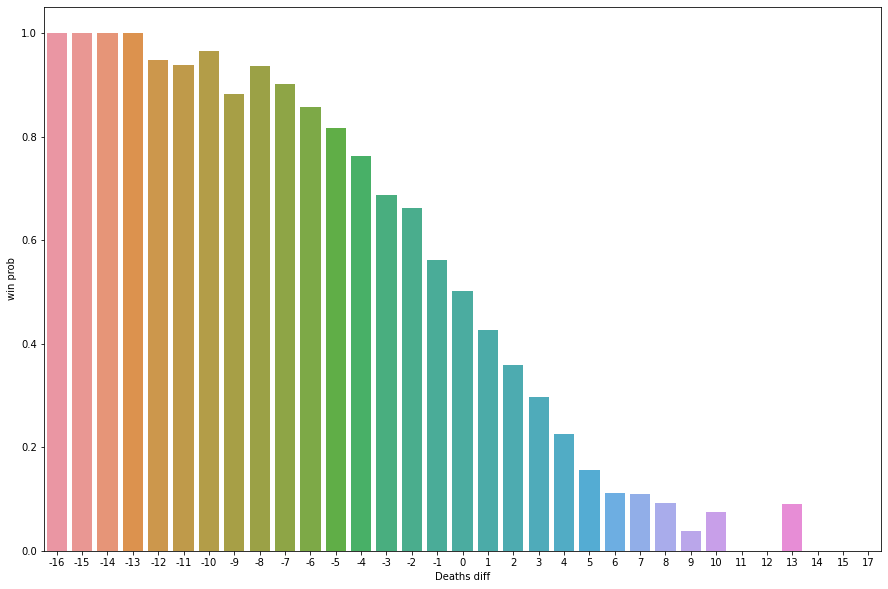

In [11]:
bt_stats['blueDeathsDiff'] = bt_stats['blueDeaths'] - rt_stats['redDeaths']


win_prob = bt_stats.groupby('blueDeathsDiff')['blueWins'].mean()
win_prob = win_prob.reset_index()
win_prob.columns = ['Deaths diff', 'win prob']

plt.figure(figsize = (15,10))
sns.barplot(x = 'Deaths diff', y = 'win prob', data = win_prob)

#### CS/min
The farming mechanism in League of Legends rewards players with gold and exp for successfully last hitting creeps (minions and monsters). Each last hit is counted in the player's CS basically quantifying how much gold he got from farming. As we did for kills we will be more interested in studying CS difference between the two teams.

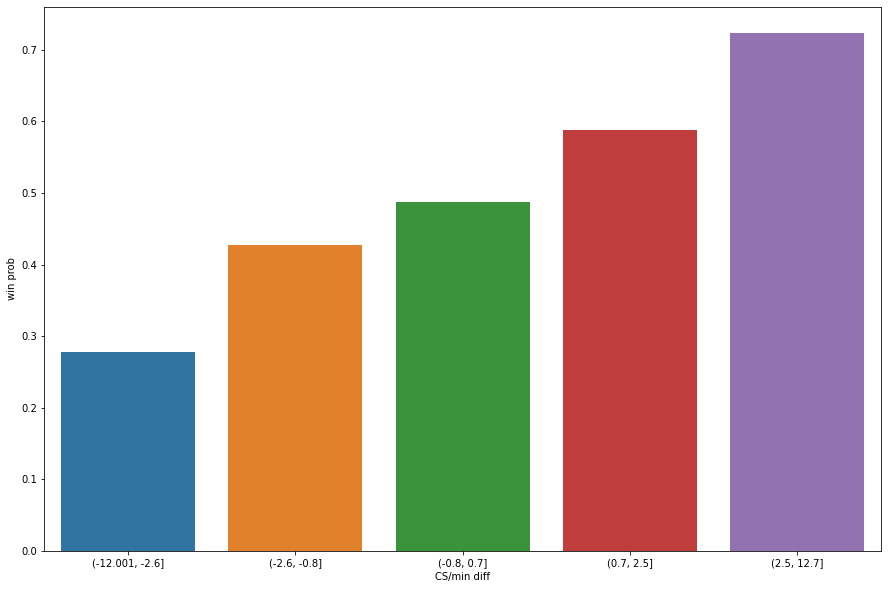

In [12]:
bt_stats['blueCSDiff'] = bt_stats['blueCSPerMin'] - rt_stats['redCSPerMin']
bt_stats['blueCSDiffBins'] = pd.qcut(bt_stats['blueCSDiff'], q = 5, duplicates='drop')

win_prob = bt_stats.groupby('blueCSDiffBins')['blueWins'].mean()
win_prob = win_prob.reset_index()
win_prob.columns = ['CS/min diff', 'win prob']

plt.figure(figsize = (15,10))
sns.barplot(x = 'CS/min diff', y = 'win prob', data = win_prob)

The larger the difference in income, the higher the chance of winning confirming that more gold = stronger probability to win.

## Experience diff / Average level
These two are strongly related and interchangeable since, for a player to level up, he needs to gain a certain amount of exp points. Upon leveling up, the player unlocks new abilities or upgrade previously unlocked ones and also gets more HP.

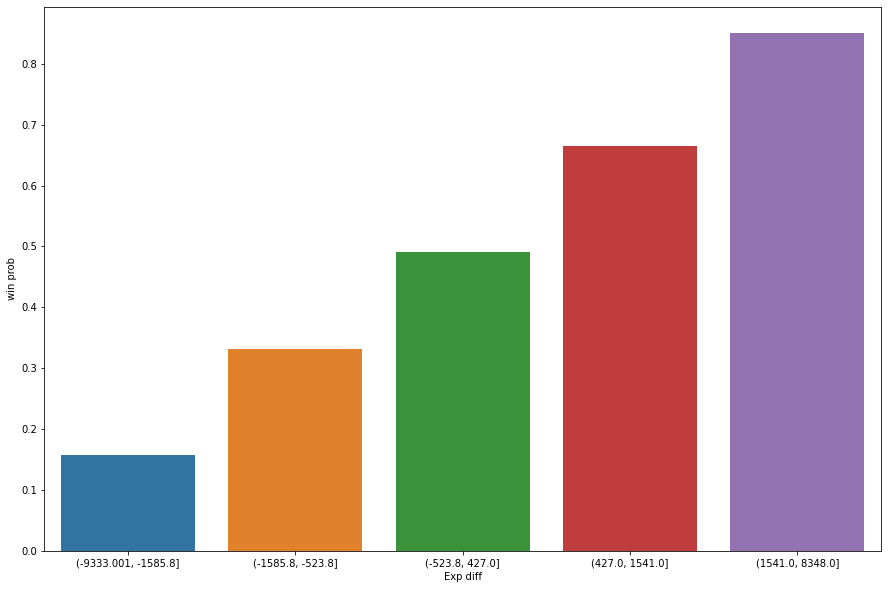

In [13]:

bt_stats['blueExperienceDiffBins'] = pd.qcut(bt_stats['blueExperienceDiff'], q = 5, duplicates='drop')

win_prob = bt_stats.groupby('blueExperienceDiffBins')['blueWins'].mean()
win_prob = win_prob.reset_index()
win_prob.columns = ['Exp diff', 'win prob']

plt.figure(figsize = (15,10))
sns.barplot(x = 'Exp diff', y = 'win prob', data = win_prob)

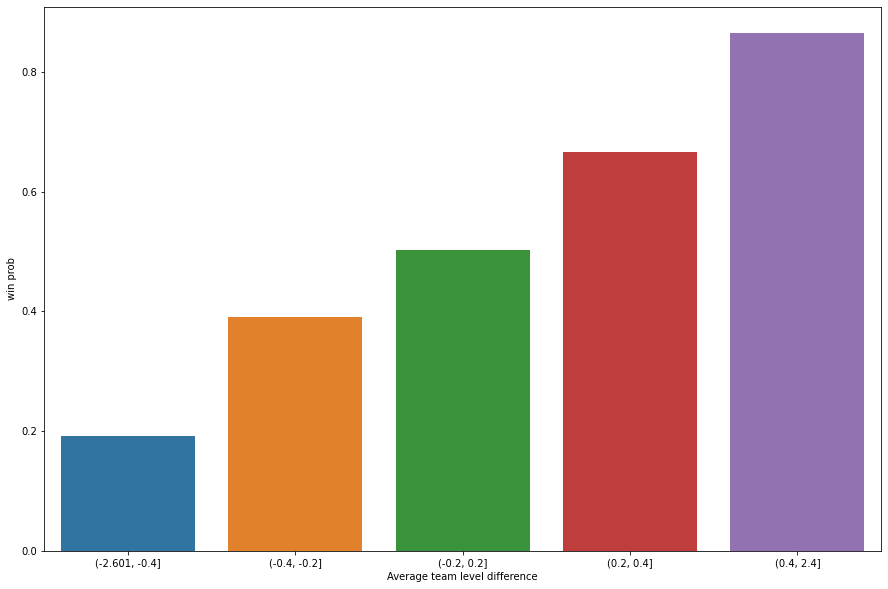

In [14]:
bt_stats['blueAvgLevelDiff'] = bt_stats['blueAvgLevel'] - rt_stats['redAvgLevel']
bt_stats['blueAvgLevelDiffBins'] = pd.qcut(bt_stats['blueAvgLevelDiff'], q = 5, duplicates='drop')

win_prob = bt_stats.groupby('blueAvgLevelDiffBins')['blueWins'].mean()
win_prob = win_prob.reset_index()
win_prob.columns = ['Average team level difference', 'win prob']

plt.figure(figsize = (15,10))
sns.barplot(x = 'Average team level difference', y = 'win prob', data = win_prob)

Exp and levels give an edge, to the team that's ahead, over the opposing team boosting their chances to win.

## Epic monsters
Epic monsters are rift heralds and dragons. They are considered as neutral objectives and killing them will give the slaying team bonus stats and/or buffs.

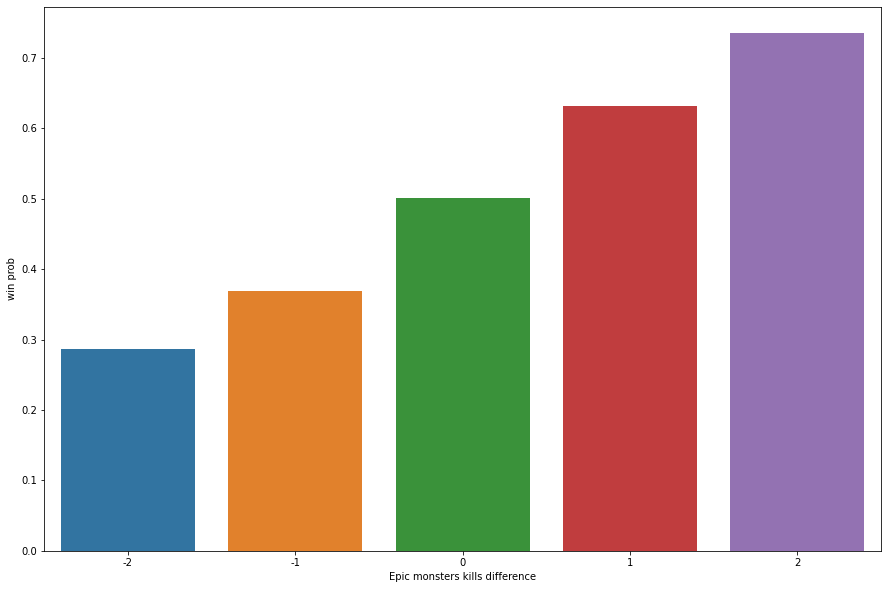

In [15]:
bt_stats['blueEliteMonstersDiff'] = bt_stats['blueEliteMonsters'] - rt_stats['redEliteMonsters']
#bt_stats['blueAvgLevelDiffBins'] = pd.qcut(bt_stats['blueAvgLevelDiff'], q = 5, duplicates='drop')

win_prob = bt_stats.groupby('blueEliteMonstersDiff')['blueWins'].mean()
win_prob = win_prob.reset_index()
win_prob.columns = ['Epic monsters kills difference', 'win prob']

plt.figure(figsize = (15,10))
sns.barplot(x = 'Epic monsters kills difference', y = 'win prob', data = win_prob)

Since we are studying the early game phase, only 2 epic monsters spawn during this time. That's why the difference ranges between 2 and -2.
Observing the graph, we see that securing at least one objective will increase the win chances significantly.

The dataset contains plenty of other features influencing teams wins/losses but they're either derived from or leading to the ones mentioned above which means that they'll have a similar impact on the outcome so visualizing them is unnecessary.

# Machine learning

In this part we'll try different machine learning algorithms, measure their prediction accuracy and f1-score, and then choose which one best fits our data.
We'll be using supervised machine learning algorithms, classification algorithms to be exact, because our data is labeled and the target value has a binary output.

#### Feature scaling and spliting data

In [16]:
x = bt_stats.iloc[:, 1:20]
y = bt_stats.iloc[:,0]

sc = StandardScaler()
sc.fit(x)
x = sc.transform(x)




#### Logistic regression

In [17]:
logreg = LogisticRegression()


##### Decision tree classifier

In [18]:


dtree = DecisionTreeClassifier(
splitter = 'random', 
min_samples_split = 5, 
max_leaf_nodes = 20, max_depth = 20)





#### Random forest classifier

In [19]:


rf = RandomForestClassifier(n_estimators = 50)








# after tweaking number of estimators and getting the best result

args = {'n_estimators' : range(50,200,50),
        'max_depth' : range (2,10,2)
        }

gscv_rf = GridSearchCV(rf, args, cv = 10)

gscv_rf.fit(x_train, y_train)
rf_pred = gscv_rf.predict(x_test)

print(f'Accuracy = {round(accuracy_score(rf_pred, y_test),3)}')
print(f'F-1 score = {round(f1(y_test, rf_pred),3)}')

Tweaks improved model's accuracy.

#### KNN classifier

In [20]:
knn = KNeighborsClassifier()






Cross validation check to determine the best model 

In [21]:
scores = cross_val_score(logreg, x, y, cv = 10)
f1_scores = cross_val_score(logreg, x, y, scoring = 'f1', cv = 10)

print(f'Accuracy = {round(scores.mean(),3)}')
print(f'F-1 score = {round(f1_scores.mean(),3)}')

Accuracy = 0.73
F-1 score = 0.73


In [22]:
scores = cross_val_score(dtree, x, y, cv = 10)
f1_scores = cross_val_score(dtree, x, y, scoring = 'f1', cv = 10)

print(f'Accuracy = {round(scores.mean(),3)}')
print(f'F-1 score = {round(f1_scores.mean(),3)}')

Accuracy = 0.721
F-1 score = 0.724


In [23]:
scores = cross_val_score(rf, x, y, cv = 10)
f1_scores = cross_val_score(rf, x, y, scoring = 'f1', cv = 10)

print(f'Accuracy = {round(scores.mean(),3)}')
print(f'F-1 score = {round(f1_scores.mean(),3)}')

Accuracy = 0.717
F-1 score = 0.716


In [24]:
scores = cross_val_score(knn, x, y, cv = 10)
f1_scores = cross_val_score(knn, x, y, scoring = 'f1', cv = 10)

print(f'Accuracy = {round(scores.mean(),3)}')
print(f'F-1 score = {round(f1_scores.mean(),3)}')

Accuracy = 0.677
F-1 score = 0.679


Logistic regression performed the best taking into consideration f1 score and accuracy.

# Conclusion

Logistic regression is the best model to fit our data therefor it's the one to be used out of all tested models.